**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [1]:
%%capture
! pip install lightgbm
! pip install implicit==0.4.4

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.insert(0, './drive/MyDrive/Colab Notebooks/RS/')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

#### read data

In [5]:
data = pd.read_csv('./drive/My Drive/MLData/data/retail_train.csv')
item_features = pd.read_csv('./drive/My Drive/MLData/data/product.csv')
user_features = pd.read_csv('./drive/My Drive/MLData/data/hh_demographic.csv')

#### Process features dataset

In [6]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [7]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

#### Split dataset for train, eval, test

In [8]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [9]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [10]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [11]:
# вывод разброса по пользователям и товарам
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [12]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


#### Prefilter items

In [13]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


#### Make cold-start to warm-start

In [14]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


#### Init/train recommender

In [15]:
recommender = MainRecommender(data_train_matcher)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

#### получить кандидатов

In [16]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [17]:
def get_recommendations(data:pd.DataFrame, user_col:str, recommend_model, top_n:int):
    """
    recommend_models' enum:
        recommender.get_own_recommendations
        recommender.get_als_recommendations
        recommender.get_similar_items_recommendation
        recommender.get_similar_users_recommendation
    """
    data[recommend_model.__name__[4:]] = data[user_col].apply(lambda x: recommend_model(x, N=top_n))

In [18]:
def calc_recall(df_data, top_k, columns=None):
    if columns is None:
        columns = df_data.columns[2:]
        
    for col_name in columns:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [19]:
N_PREDICT = 50 
get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_als_recommendations, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_similar_items_recommendation, N_PREDICT)
get_recommendations(result_eval_matcher, USER_COL, recommender.get_similar_users_recommendation, N_PREDICT)
result_eval_matcher.head(5)

,user_id,actual,own_recommendations,als_recommendations,similar_items_recommendation,similar_users_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1084551, 849205, 6773188, 1036930, 1086001, 8...","[8353113, 820518, 9575315, 934172, 1084551, 67...","[933102, 908314, 12352249, 1036495, 1102003, 6..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[1084551, 1031316, 956127, 1023466, 854261, 90...","[1026550, 890490, 958067, 1082269, 9677149, 89...","[835578, 936830, 835499, 955921, 8090956, 9881..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1084551, 910151, 1114435, 1044207, 906449, 90...","[979452, 9803810, 1016421, 7166865, 880469, 84...","[1000925, 1011926, 1123106, 1108131, 5574377, ..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 972416, 995598, 923600, 1138596, 10...","[906449, 956127, 848878, 1084551, 999142, 8651...","[963194, 890490, 1131382, 999250, 1006664, 104...","[829349, 1057168, 852015, 992650, 1116253, 938..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 894360, 7147142, 9338009, 896666, 939...","[1084551, 906449, 976335, 6633167, 906864, 111...","[865456, 958067, 7441272, 1137383, 917532, 955...","[7168058, 1042915, 1057168, 1114653, 848684, 1..."


In [20]:
TOPK_RECALL = 50
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_recommendations', 0.06525657038145175),
 ('similar_items_recommendation', 0.010868963245501134),
 ('als_recommendations', 0.003588755210142619),
 ('similar_users_recommendation', 0.0018783519632031313)]

<span style="color:red">лучший recall дала модель ItemItemRecommender </span>

#### проверка влияния top-popular на recall для own_recommendations

In [21]:
overall_top_purchases = recommender.overall_top_purchases.copy()
recommender.overall_top_purchases = [999999]*N_PREDICT
get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, N_PREDICT)
sorted(calc_recall(result_eval_matcher, TOPK_RECALL, ['own_recommendations']), key=lambda x: x[1],reverse=True)

[('own_recommendations', 0.06018145687107224)]

In [22]:
recommender.overall_top_purchases = overall_top_purchases.copy()

<span style="color:red">на сколько процентов модель даёт лучшие результаты по recall для own_recommendations с дополнением top-popular </span>

In [23]:
(0.06525657038145175-0.06018145687107224) / 0.06525657038145175 * 100

7.77716861415388

#### Как зависит recall@k от k

In [24]:
COL_OWN_REC = 'own_recommendations' 
k_vals = [20, 50, 100, 200, 500]
result = []
for k in k_vals:
    get_recommendations(result_eval_matcher, USER_COL, recommender.get_own_recommendations, k)
    result.append(dict(calc_recall(result_eval_matcher, k, [COL_OWN_REC]))[COL_OWN_REC])

Text(0, 0.5, 'recall_at_k')

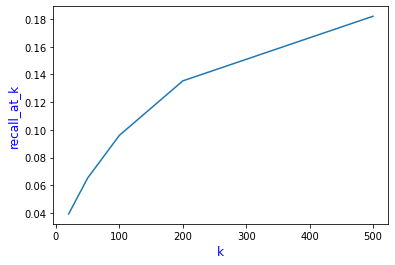

In [25]:
plt.plot(k_vals, result)
plt.xlabel('k', fontsize=12, color='blue')
plt.ylabel('recall_at_k', fontsize=12, color='blue')

<span style="color:red"> понятно, что чем больше количество рекомендаций, тем больше релевантных товаров будет в списке рекомендаций, т.е. тем больше будет recall. С увеличением к график recall замедляется. Значительно замедлился рост при к = 200. Т.е. разумным будет принять к равным 200, но такое большое количество рекомендаций не всегда необходимо, всё зависит от поставленной задачи </span>

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

#### Обучаем модель 2-ого уровня на выбранных кандидатах

Подготовка данных для трейна

In [26]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [27]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [28]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [29]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(5)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640
0,2070,928263


#### Check warm start

In [30]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (107550, 2) Users: 2151 Items: 4574


#### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [31]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [32]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [33]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [34]:
df_ranker_train.target.value_counts()

0.0    99177
1.0     7795
Name: target, dtype: int64

In [35]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


#### Подготавливаем фичи для обучения модели

In [36]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [37]:
data_train_ranker.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


##### Фичи user_id

In [38]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [39]:
data_train_ranker_copy = data_train_ranker.copy()
data_train_ranker_copy = data_train_ranker_copy.merge(item_features, on='item_id', how='left')

# Кол-во покупок в каждой категории
cat_sales_count = data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(user_cat_sales_count=('quantity','sum'))

# Сумма покупок в каждой категории
cat_sales_value = data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(user_cat_sales_value=('sales_value','sum'))

df_ranker_train = df_ranker_train.merge(cat_sales_count, on=['user_id', 'department'], how='inner')
df_ranker_train = df_ranker_train.merge(cat_sales_value, on=['user_id', 'department'], how='inner')

# Средняя сумма покупки 1 товара в каждой категории
df_ranker_train['user_mean_item_price_in_cat'] = df_ranker_train.user_cat_sales_value.\
    div(df_ranker_train.user_cat_sales_count, axis=0)

# Средний чек
mean_sales_value = data_train_ranker_copy.groupby(by=['user_id', 'basket_id']).agg(user_mean_sales_value=('sales_value','sum')).\
    groupby(by=['user_id']).mean()
df_ranker_train = df_ranker_train.merge(mean_sales_value, on=['user_id'], how='inner')

df_ranker_train.sample(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_cat_sales_count,user_cat_sales_value,user_mean_item_price_in_cat,user_mean_sales_value
89501,758,5569845,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5.18,1.726667,11.170000
22590,786,5570048,1.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,19-24,U,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,139,377.08,2.712806,55.983000
4637,895,1085031,1.0,759,GROCERY,National,YOGURT,YOGURT MULTI-PACKS,4 PK/7 OZ,45-54,U,150-174K,Unknown,Single Male,1,None/Unknown,208,428.79,2.061490,53.703846


##### Фичи item_id

In [41]:
# Кол-во покупок в неделю
week_sales_count = round(data_train_ranker_copy.groupby(by=['item_id']).agg(item_week_sales_count=('quantity','sum')) / \
        data_train_ranker_copy.week_no.nunique(), 3)


# Среднее кол-во покупок 1 товара в категории в неделю
mean_week_sales_count = round(data_train_ranker_copy.groupby(by=['item_id', 'department']).agg(item_mean_week_sales_count=('quantity','sum'))  / \
        data_train_ranker_copy.week_no.nunique(), 3)

df_ranker_train = df_ranker_train.merge(week_sales_count, on=['item_id'], how='inner')
df_ranker_train = df_ranker_train.merge(mean_week_sales_count, on=['item_id', 'department'], how='inner')

df_ranker_train.sample(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_cat_sales_count,user_cat_sales_value,user_mean_item_price_in_cat,user_mean_sales_value,item_week_sales_count,item_mean_week_sales_count
47743,1949,1048833,1.0,1329,GROCERY,National,DRY BN/VEG/POTATO/RICE,RICE - DRY BAG AND BOX,32 OZ,45-54,...,Unknown,Single Female,1,None/Unknown,132,252.55,1.913258,42.986667,1.833,1.833
78351,2135,923723,0.0,1377,GROCERY,National,SHORTENING/OIL,COOKING SPRAYS,8 OZ,NaN,...,NaN,NaN,NaN,NaN,9,11.16,1.240000,11.203333,1.000,1.000
56626,622,832526,0.0,1543,GROCERY,National,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1/2 GAL,35-44,...,Unknown,Single Female,1,None/Unknown,25,55.08,2.203200,11.396667,0.167,0.167


##### Фичи user_id - item_id

In [42]:
# #  Кол-во покупок юзером конкретной категории в неделю
# week_cat_sales_count = round(data_train_ranker_copy.groupby(by=['user_id', 'department']).agg(ui_week_cat_sales_count=('quantity','sum')) /\
#         data_train_ranker_copy.week_no.nunique(), 3)

# #  Среднее кол-во покупок всеми юзерами конкретной категории в неделю 
# mean_week_cat_sales_count = round(data_train_ranker_copy.groupby(by=['department']).agg(ui_mean_week_cat_sales_count=('quantity','sum'))/\
#         data_train_ranker_copy.week_no.nunique(), 3)

# df_ranker_train = df_ranker_train.merge(week_cat_sales_count, on=['user_id', 'department'], how='inner')
# df_ranker_train = df_ranker_train.merge(mean_week_sales_count, on=['department'], how='inner')


In [43]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [44]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

# X_train = pd.get_dummies(X_train)
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_cat_sales_count,user_cat_sales_value,user_mean_item_price_in_cat,user_mean_sales_value,item_week_sales_count,item_mean_week_sales_count
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,...,Unknown,Unknown,1,None/Unknown,3,10.79,3.596667,14.355581,0.833,0.833
1,1434,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,NaN,NaN,...,NaN,NaN,NaN,NaN,3,7.56,2.520000,17.525000,0.833,0.833
2,900,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,35-44,A,...,Homeowner,2 Adults No Kids,2,None/Unknown,25,79.45,3.178000,13.454390,0.833,0.833
3,842,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,NaN,NaN,...,NaN,NaN,NaN,NaN,2,8.14,4.070000,20.744815,0.833,0.833
4,1142,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,A,...,Homeowner,2 Adults No Kids,2,None/Unknown,27,102.00,3.777778,62.512222,0.833,0.833


In [45]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [46]:
df_ranker_predict = df_ranker_train.copy()

In [47]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [48]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [49]:
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [50]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [52]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [53]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [54]:
TOPK_PRECISION = 5
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.17016806722688915)
('own_rec', 0.1444117647058813)


precision на двухуровневой модели вырос. При более детальной настройке модели LGBMClassifier можно добиться ещё лучших результатов. При обработке категориальных переменных - преобразовании в двоичную кодировку (pd.get_dummies), precision получился ниже, чем без преобразования (0.155) 